# SENSITIVITY ANALYSES
------------------------

## Import Libraries

In [1]:
github_dir = "/home/kiran/Documents/github/CCAS_ML"

# add path to local functions
import os
os.chdir(github_dir)

# import all the params for this model
from example_params import *
is_forked = True # is going to need to go into the params file

# import own functions
import preprocess.preprocess_functions as pre
import postprocess.evaluation_metrics_functions_old as metrics
import postprocess.merge_predictions_functions as ppm
import model.specgen_batch_generator as bg
import model.network_class as rnn
# import postprocess.visualise_prediction_functions as pp
from model.callback_functions import LossHistory
import model.audiopool as audiopool

# import normal packages used in pre-processing
import numpy as np
import librosa
import warnings
import ntpath
import os
from itertools import compress  
from random import random, shuffle
from math import floor
import statistics
import glob

# plotting
import matplotlib.pyplot as plt

# ML section packages
import datetime
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Input, Flatten
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Activation, SeparableConv2D, concatenate
from keras.layers import Reshape, Permute
from keras.layers import TimeDistributed, Dense, Dropout, BatchNormalization
from keras.models import load_model
from keras.layers import GRU, Bidirectional, GlobalAveragePooling2D
from keras.callbacks import TensorBoard
from keras.utils import plot_model

# postprocessfrom decimal import Decimal
from decimal import Decimal
import pandas as pd
import pickle

# evaluate and plot 
import seaborn as sn
# import pandas as pd
# import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import csv

/home/kiran/anaconda3/envs/ML1_env/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/home/kiran/anaconda3/envs/ML1_env/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Using TensorFlow backend.


----------------------------------------------------------------------
# PREPROCESSING / DATA WRANGLING

Currently, all the meerkat files are found on the server. The labels in particular are divided by year (currently 2017 and 2019) and all file labels are in a single document. This bit of code just takes these and puts them together

In [2]:
# Compile all the synched label files together
labels_all = pd.DataFrame()
for directory in label_dirs:
    for group in group_IDs:
        temp = pd.read_csv(os.path.join(directory, group +"_ALL_CALLS_SYNCHED.csv"), sep=sep,
                       header=0, engine = engine, encoding = encoding) 
        temp["group"] = group
        labels_all = pd.concat([labels_all, temp]) 
        del temp

labels_all = labels_all[-labels_all.wavFileName.str.contains('SOUNDFOC')]
labels_all = labels_all.reset_index(drop = True)

Data also contain focal follows (someone walking around behind the meerkats) and the resultion of this data is different and therefore not anlysed with the collar data (but could be done separately or put to the same resolution).

In [3]:
# subset all the audio files that we should use in the analysis (i.e. not focal follow data)
audio_files = list(set(labels_all["wavFileName"]))
audio_filenames = list(compress(audio_files, ["SOUNDFOC" not in filei for filei in audio_files]))

# subset all the audio files that we should use in the analysis (i.e. not focal follow data)
label_files = list(set(labels_all["csvFileName"]))
label_filenames = list(compress(label_files, ["SOUNDFOC" not in filei for filei in label_files]))

# get the file IDS without all the extentions (used later for naming)
all_filenames = [audio_filenames[i].split(".")[0] for i in range(0,len(audio_filenames))]

Then we locate all the paths to the files

In [4]:
# find all the labels
EXT = "*.csv"
label_filepaths = []
for PATH in acoustic_data_path :
      label_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])
EXT = "*.CSV"
for PATH in acoustic_data_path :
      label_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])

# find all audio paths (will be longer than label path as not everything is labelled)
audio_filepaths = []
EXT = "*.wav"
for PATH in audio_dirs:
      audio_filepaths.extend( [file for path, subdir, files in os.walk(PATH) for file in glob.glob(os.path.join(path, EXT))])

### Create a label table

Currently, the labels are stored in a file generated by audition for the meerkats. We want to these manual labels and put them into a more meaningful categories for for the machine learning. To set categories, I use a pre-defined dictionary called call_types that is defined in the parameters file and which specifies what the different classes are for the call types. Anything strange gets put into a category "oth" for other.

In [5]:
# Create the label table
label_table = pre.create_meerkat_table(labels_all, call_types, sep,
                                       start_column, duration_column, columns_to_keep,
                                       label_column, convert_to_seconds, 
                                       label_for_other, label_for_noise, engine,
                                       multiclass_forbidden)

This label 'c' on line 5909 will be classed as 'oth'
This label 'c' on line 7266 will be classed as 'oth'
This label 'cn' on line 7921 will be classed as 'oth'
This label 'chew' on line 8385 will be classed as 'oth'
This label 'sb' on line 8504 will be classed as 'oth'
This label 'chew' on line 8782 will be classed as 'oth'
This label 'chew' on line 8862 will be classed as 'oth'
This label 'chew' on line 8886 will be classed as 'oth'
This label 'chew' on line 8887 will be classed as 'oth'
This label 'chew' on line 8890 will be classed as 'oth'
This label 'chew' on line 8914 will be classed as 'oth'
This label 'chew' on line 8933 will be classed as 'oth'
This label 'chew' on line 8962 will be classed as 'oth'
This label 'chew' on line 9008 will be classed as 'oth'
This label 'chew' on line 9011 will be classed as 'oth'
This label 'chew' on line 9045 will be classed as 'oth'
This label 'chew' on line 9046 will be classed as 'oth'
This label 'chew' on line 9243 will be classed as 'oth'
Th

In [6]:
# estimate the average beep length because many of them are not annotated in the data
avg_beep = round(statistics.mean(label_table.loc[label_table["beep"],"Duration"].loc[label_table.loc[label_table["beep"],"Duration"]>0]),3)
label_table.loc[(label_table["beep"].bool and label_table["Duration"] == 0.) ==True, "Duration"] = avg_beep
label_table.loc[(label_table["beep"].bool and label_table["Duration"] == avg_beep) ==True, "End"] += avg_beep
print(avg_beep)

0.068


In [7]:
# add wav and audio paths
label_table["wav_path"] = label_table['wavFileName'].apply(lambda x: [pathi for pathi in audio_filepaths if x in pathi][0])
label_table["label_path"] = label_table['csvFileName'].apply(lambda x: [pathi for pathi in label_filepaths if x in pathi][0])

In [8]:
# make sure these paths are added to the noise table too
columns_to_keep.append("wav_path")
columns_to_keep.append("label_path")

# create the matching noise table
noise_table = pre.create_noise_table(label_table, call_types, label_for_noise, label_for_startstop, columns_to_keep)#, '\$'])

# remove rows where the annotated noise is smaller than the window size otherwise the spectrogram we generate will inclue a call
noise_table = noise_table.drop(noise_table[noise_table["Duration"] < spec_window_size].index)

# YEAR and GROUP SENSITIVITY ANALYSIS

audio_filenames Here we split the training and test set based on files (rather than spectrograms). 






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where










Epoch 1/200
140/140 [==============================] - 213s 2s/step - loss: 1.3734 - output_calltype_loss: 1.3627 - output_callpresence_loss: 0.2136 - output_calltype_categorical_accuracy: 0.6937 - output_callpresence_binary_accuracy: 0.7099 - val_loss: 1.1993 - val_output_calltype_loss: 1.1891 - val_output_callpresence_loss: 0.2042 - val_output_calltype_categorical_accuracy: 0.6838 - val_output_callpresence_binary_accuracy: 0.6974

Epoch 2/200
140/140 [==============================] - 200s 1s/step - loss: 1.1341 - output_calltype_loss: 1.1248 - output_callpresence_loss: 0.1857 - output_calltype_categorical_accuracy: 0.7057 - output_callpresence_binary_accuracy: 0.7410 - val_loss: 1.3579 - val_output_calltype_loss: 1.3469 - val_output_callpresence_loss: 0.2185 - va

Layer bidirectional_1 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_2:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).
Layer bidirectional_2 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_2:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).


/media/kiran/D0-P1/animal_data/meerkat/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_L2019_HM2019/trained_model/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_L2019_HM2019_2021-12-20_21:22:45.719675
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 201, 30, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 201, 30, 128) 1280        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 201, 6, 128)  0           conv2d_1[0][0]                   
___________________________________________________________________


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 7437
Detecting calls in probability streams:  1000 / 7437
Detecting calls in probability streams:  2000 / 7437
Detecting calls in probability streams:  3000 / 7437
Detecting calls in probability streams:  4000 / 7437
Detecting calls in probability streams:  5000 / 7437
Detecting calls in probability streams:  6000 / 7437
Detecting calls in probability streams:  7000 / 7437
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.6
Detecting calls in probability streams:  0 / 7437
Detecting calls in probability streams:  1000 / 7437
Detecting calls in probability streams:  2000 / 7437
Detecting calls in probability streams:  3000 / 7437
Detecting calls in probability streams:  4000 / 7437
Detecting calls in probability streams:  5000 / 7437
Detecting calls in probability streams:  6000 / 7437
D

There is a missing start or stop in this file and it has been skipped: /home/kiran/Documents/MPI-Server/EAS_shared/meerkat/archive/rawdata/MEERKAT_RAW_DATA/2017/HM_2017_2/COLLAR/AUDIO/HM_VHMM002_HRT_R09_20170821-20170825/HM_VHMM002_HRT_R09_20170821-20170825_file_4_(2017_08_23-06_44_59)_ASWMUX221110.wav


*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 7273
Detecting calls in probability streams:  1000 / 7273
Detecting calls in probability streams:  2000 / 7273
Detecting calls in probability streams:  3000 / 7273
Detecting calls in probability streams:  4000 / 7273
Detecting calls in probability streams:  5000 / 7273
Detecting calls in probability streams:  6000 / 7273
Detecting calls in probability streams:  7000 / 7273
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.6
Detecting calls in probability streams:  0 / 7273
Detecting calls in probability streams:  1000 / 7273
Detecting calls in probability streams:  2000 / 7273
Detecting calls in probability streams:  3000 / 7273
Detecting calls in probability streams:  4000 / 7273
Detecting calls in probability streams:  5000 / 7273
Detecting calls in probability streams:  6000 / 7273
D

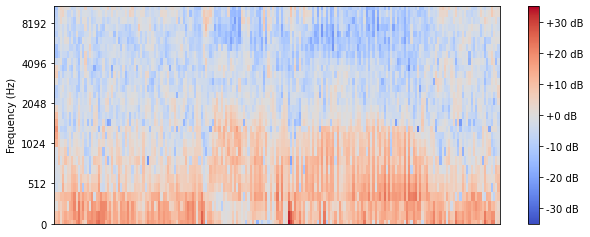

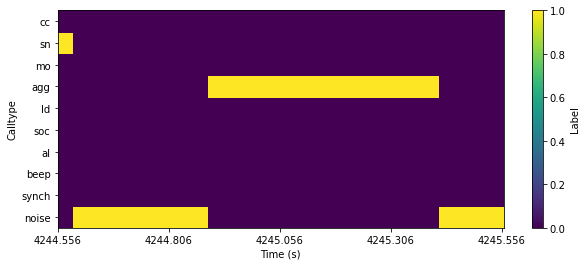

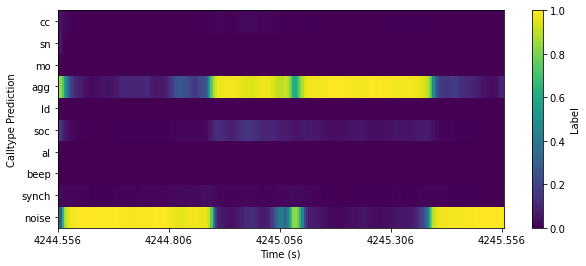

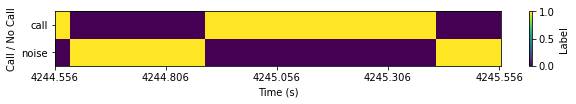

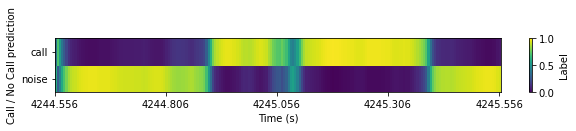

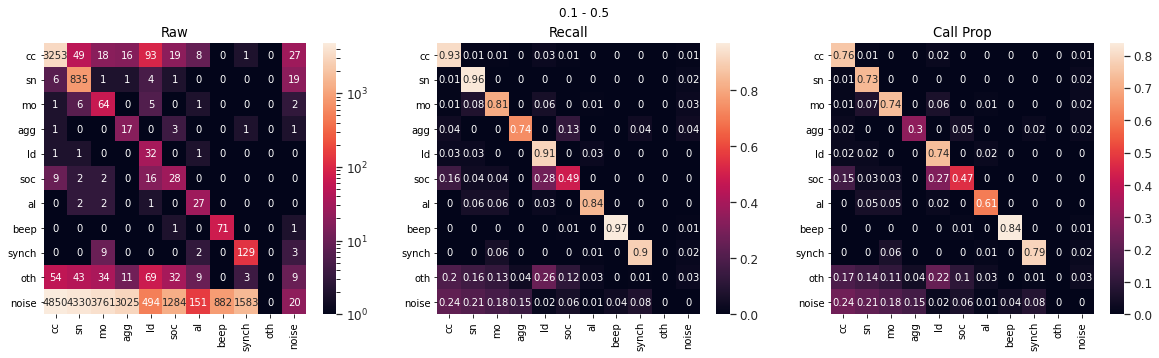

<Figure size 432x288 with 0 Axes>

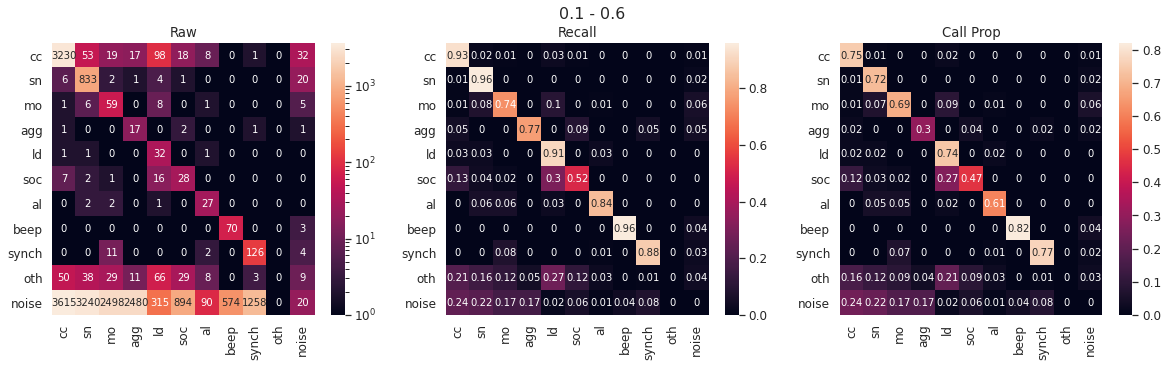

<Figure size 432x288 with 0 Axes>

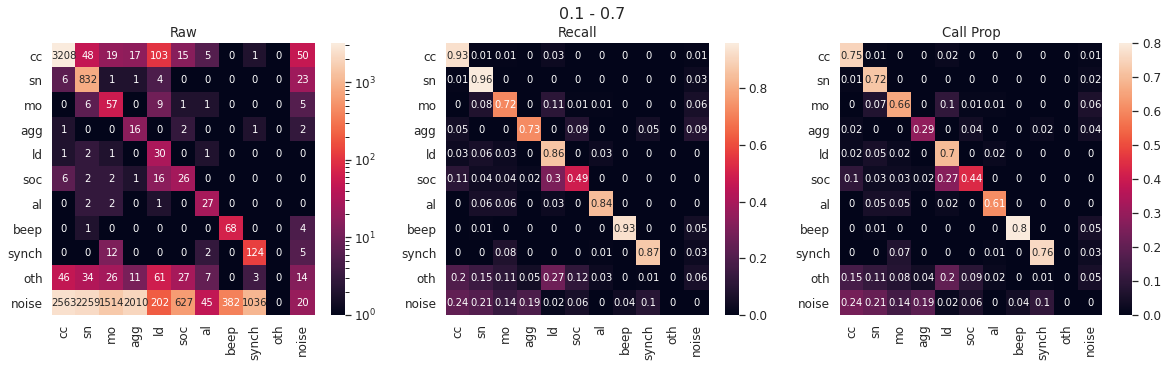

<Figure size 432x288 with 0 Axes>

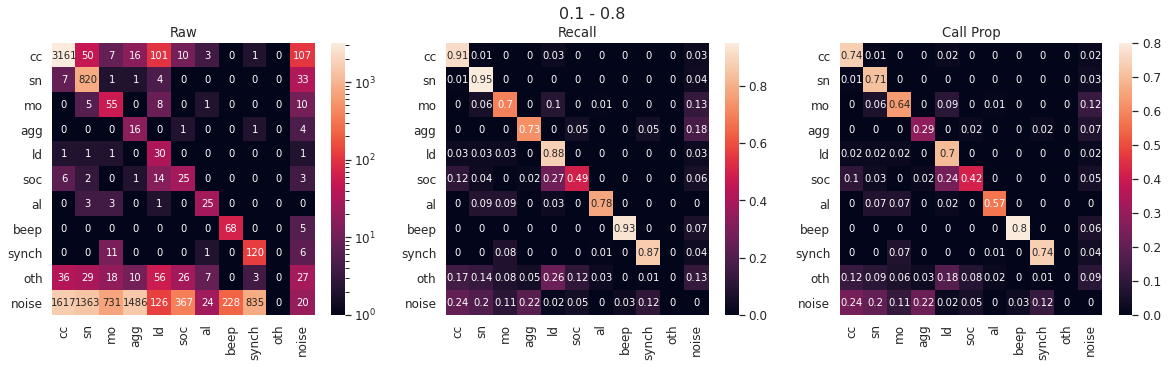

<Figure size 432x288 with 0 Axes>

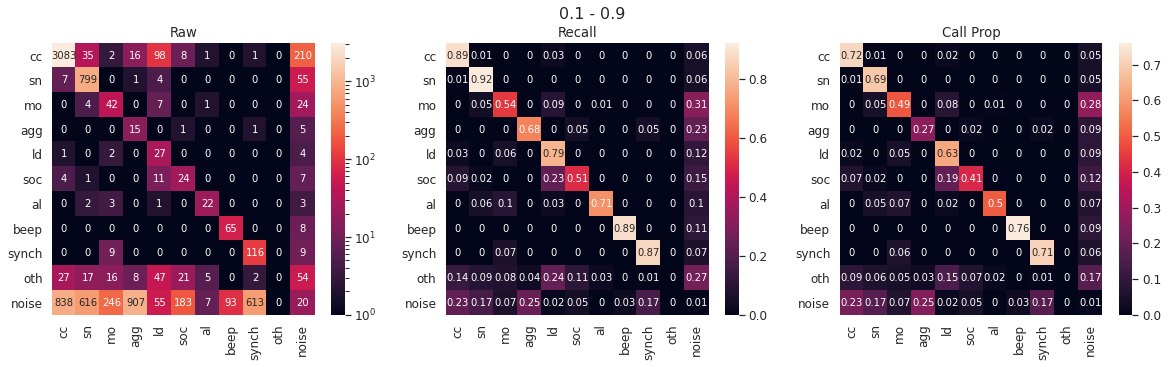

<Figure size 432x288 with 0 Axes>

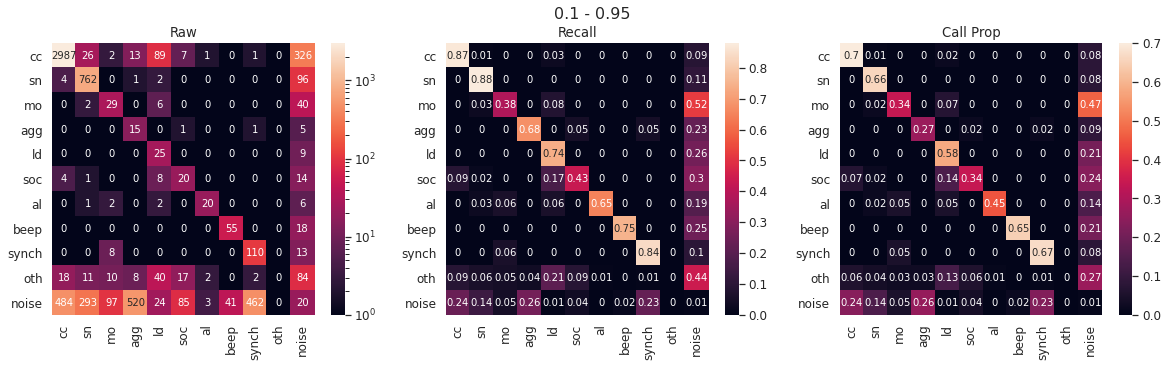

Epoch 1/200
140/140 [==============================] - 216s 2s/step - loss: 1.3548 - output_calltype_loss: 1.3442 - output_callpresence_loss: 0.2127 - output_calltype_categorical_accuracy: 0.7011 - output_callpresence_binary_accuracy: 0.7102 - val_loss: 1.1942 - val_output_calltype_loss: 1.1840 - val_output_callpresence_loss: 0.2035 - val_output_calltype_categorical_accuracy: 0.6900 - val_output_callpresence_binary_accuracy: 0.7030
Epoch 2/200
140/140 [==============================] - 205s 1s/step - loss: 1.0917 - output_calltype_loss: 1.0831 - output_callpresence_loss: 0.1725 - output_calltype_categorical_accuracy: 0.7155 - output_callpresence_binary_accuracy: 0.7626 - val_loss: 1.1403 - val_output_calltype_loss: 1.1319 - val_output_callpresence_loss: 0.1680 - val_output_calltype_categorical_accuracy: 0.6994 - val_output_callpresence_binary_accuracy: 0.8051
Epoch 3/200
140/140 [==============================] - 203s 1s/step - loss: 0.9858 - output_calltype_loss: 0.9791 - output_callp

Layer bidirectional_3 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_4:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).
Layer bidirectional_4 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_4:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).


/media/kiran/D0-P1/animal_data/meerkat/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_HM2017_HM2019/trained_model/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_HM2017_HM2019_2021-12-21_08:29:37.851122
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 201, 30, 1)   0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 201, 30, 128) 1280        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 201, 6, 128)  0           conv2d_4[0][0]                   
_________________________________________________________________


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 2956
Detecting calls in probability streams:  1000 / 2956
Detecting calls in probability streams:  2000 / 2956
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.6
Detecting calls in probability streams:  0 / 2956
Detecting calls in probability streams:  1000 / 2956
Detecting calls in probability streams:  2000 / 2956
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.7
Detecting calls in probability streams:  0 / 2956
Detecting calls in probability streams:  1000 / 2956
Detecting calls in probability streams:  2000 / 2956
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.8
Detecting calls in probability streams:  0 / 2956
Detecting calls in probability streams:  1000 / 2956
Detecting

<Figure size 432x288 with 0 Axes>

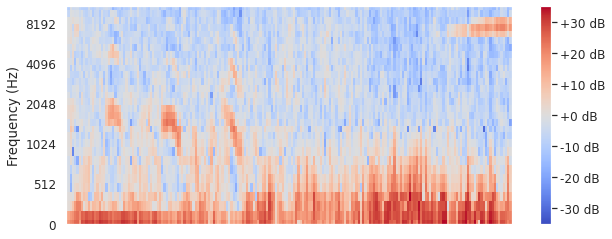

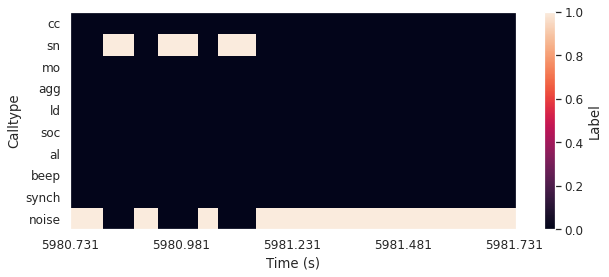

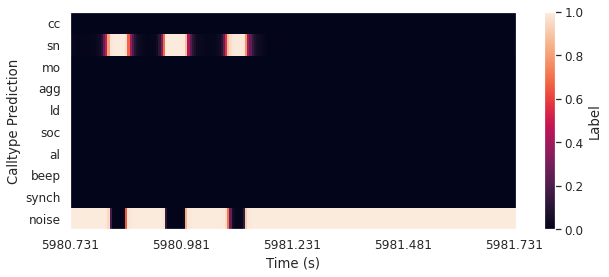

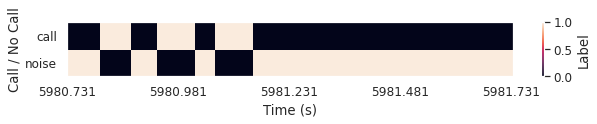

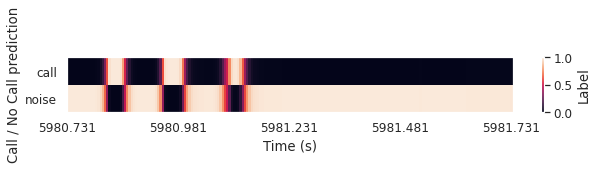

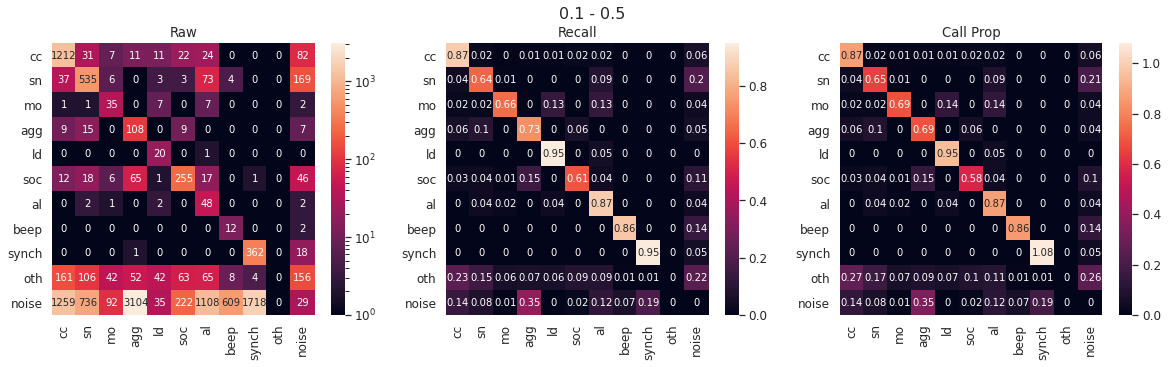

<Figure size 432x288 with 0 Axes>

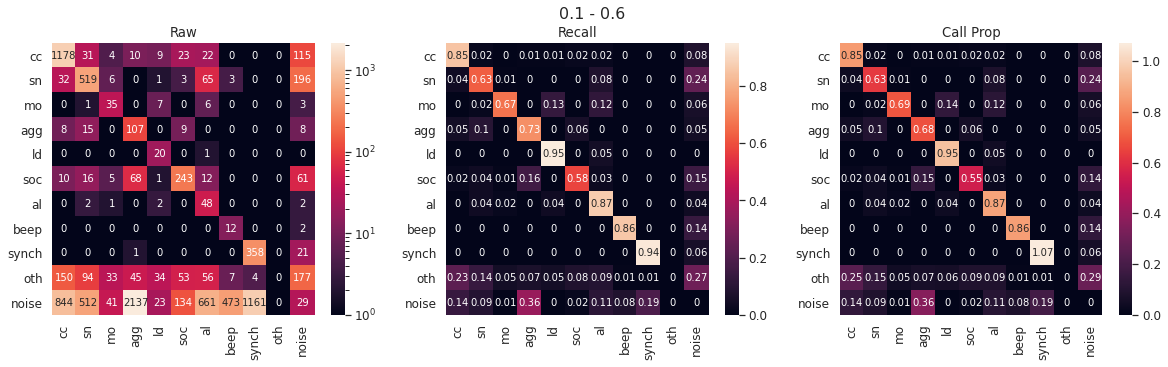

<Figure size 432x288 with 0 Axes>

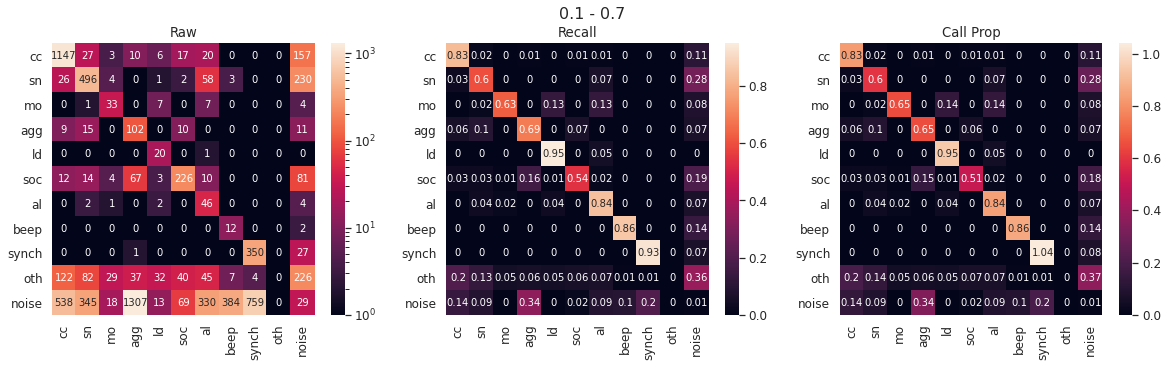

<Figure size 432x288 with 0 Axes>

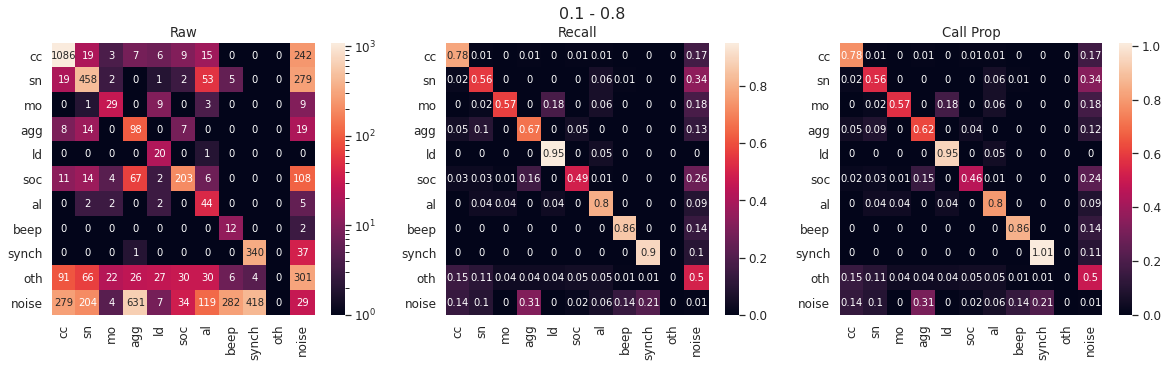

<Figure size 432x288 with 0 Axes>

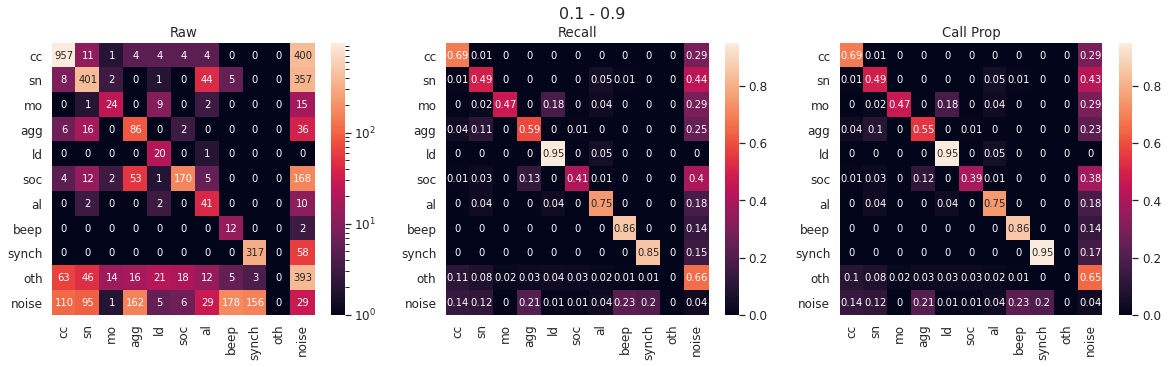

<Figure size 432x288 with 0 Axes>

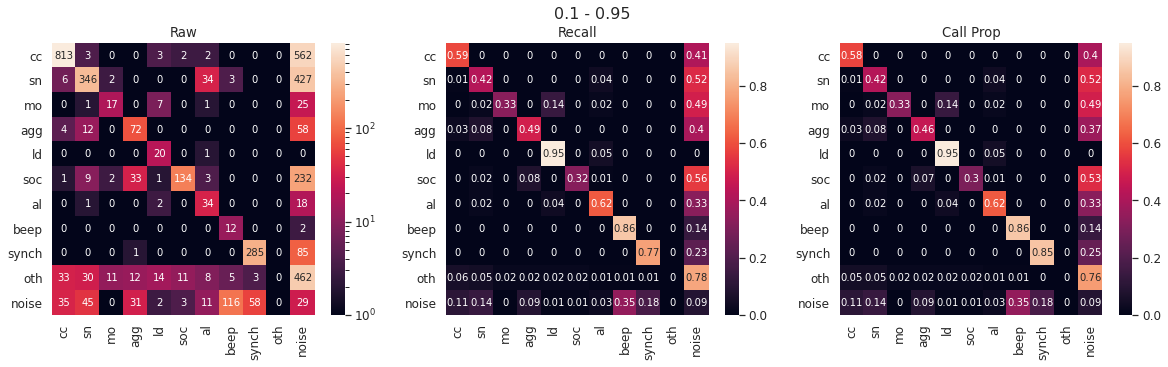

Epoch 1/200
101/101 [==============================] - 152s 2s/step - loss: 1.4129 - output_calltype_loss: 1.4021 - output_callpresence_loss: 0.2160 - output_calltype_categorical_accuracy: 0.6914 - output_callpresence_binary_accuracy: 0.7047 - val_loss: 1.1858 - val_output_calltype_loss: 1.1757 - val_output_callpresence_loss: 0.2027 - val_output_calltype_categorical_accuracy: 0.6878 - val_output_callpresence_binary_accuracy: 0.7079
Epoch 2/200
101/101 [==============================] - 136s 1s/step - loss: 1.1670 - output_calltype_loss: 1.1570 - output_callpresence_loss: 0.1991 - output_calltype_categorical_accuracy: 0.7070 - output_callpresence_binary_accuracy: 0.7204 - val_loss: 1.2365 - val_output_calltype_loss: 1.2271 - val_output_callpresence_loss: 0.1891 - val_output_calltype_categorical_accuracy: 0.6977 - val_output_callpresence_binary_accuracy: 0.7170
Epoch 3/200
101/101 [==============================] - 135s 1s/step - loss: 1.0814 - output_calltype_loss: 1.0730 - output_callp

Layer bidirectional_5 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_6:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).
Layer bidirectional_6 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_6:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).


/media/kiran/D0-P1/animal_data/meerkat/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_L2019/trained_model/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_L2019_2021-12-21_16:44:24.437377
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 201, 30, 1)   0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 201, 30, 128) 1280        input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 201, 6, 128)  0           conv2d_7[0][0]                   
_________________________________________________________________________________


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 5375
Detecting calls in probability streams:  1000 / 5375
Detecting calls in probability streams:  2000 / 5375
Detecting calls in probability streams:  3000 / 5375
Detecting calls in probability streams:  4000 / 5375
Detecting calls in probability streams:  5000 / 5375
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.6
Detecting calls in probability streams:  0 / 5375
Detecting calls in probability streams:  1000 / 5375
Detecting calls in probability streams:  2000 / 5375
Detecting calls in probability streams:  3000 / 5375
Detecting calls in probability streams:  4000 / 5375
Detecting calls in probability streams:  5000 / 5375
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.7
Detecting calls in probability streams:  0 / 5375
Detec

<Figure size 432x288 with 0 Axes>

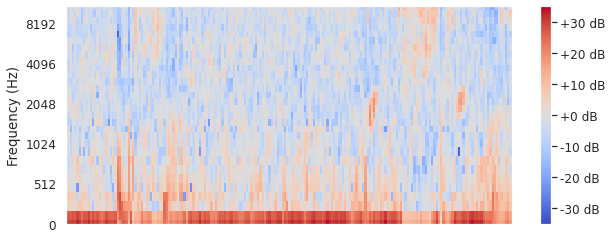

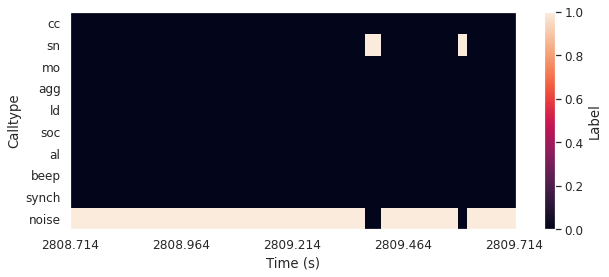

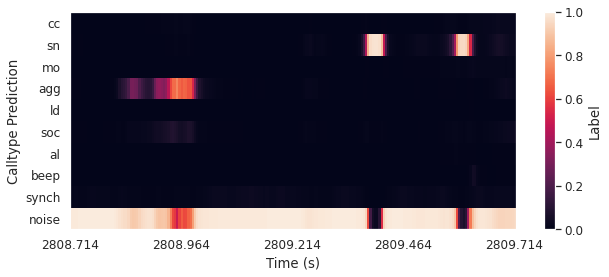

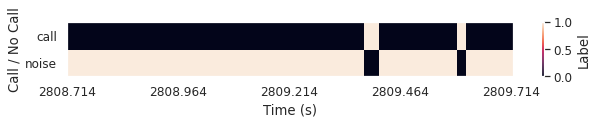

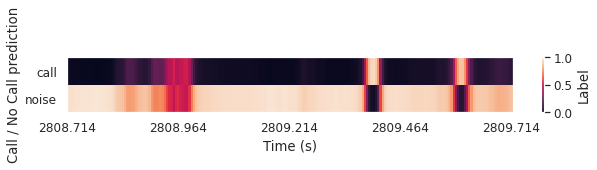

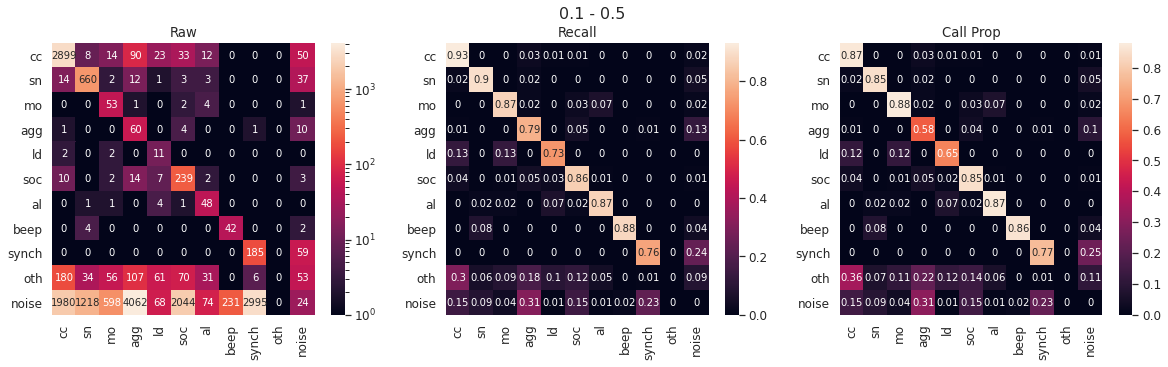

<Figure size 432x288 with 0 Axes>

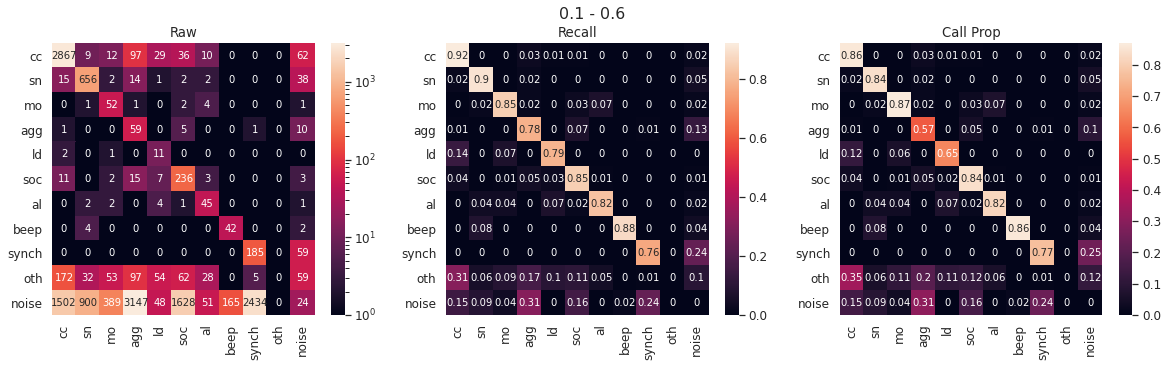

<Figure size 432x288 with 0 Axes>

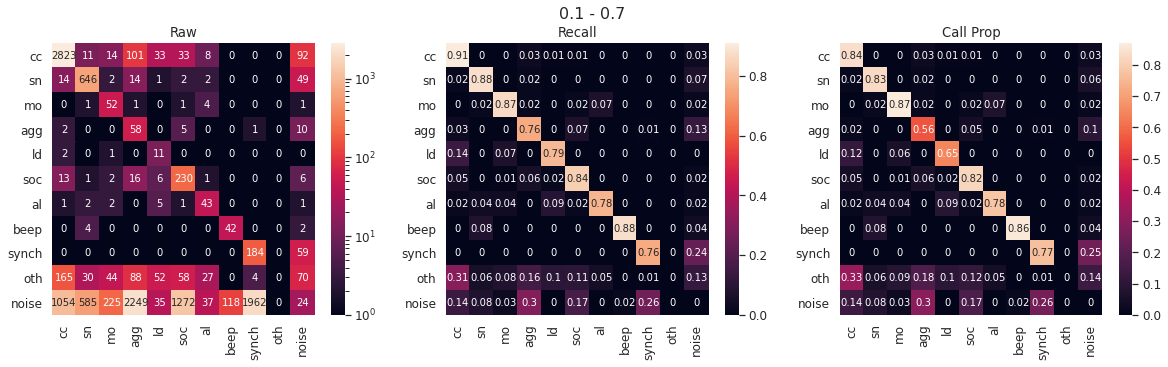

<Figure size 432x288 with 0 Axes>

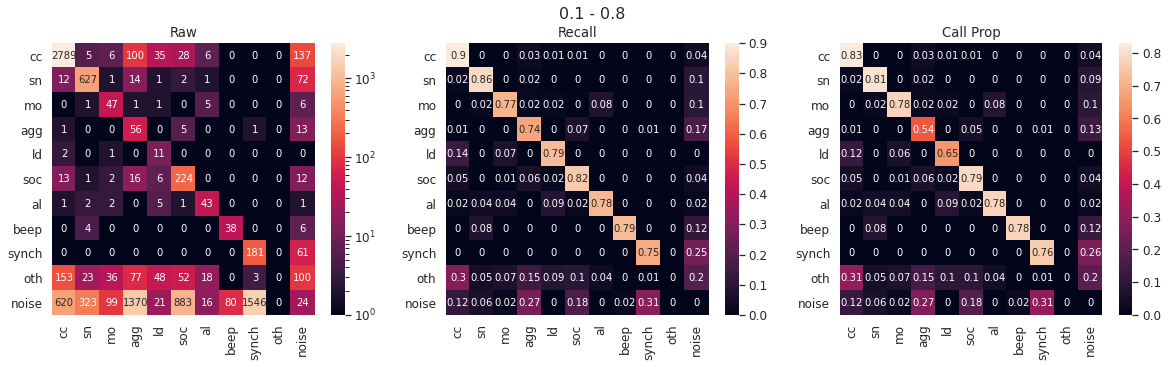

<Figure size 432x288 with 0 Axes>

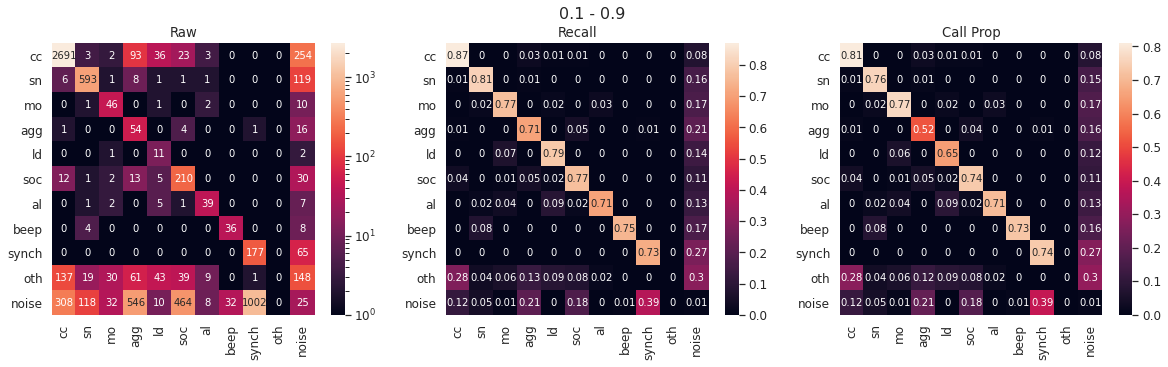

<Figure size 432x288 with 0 Axes>

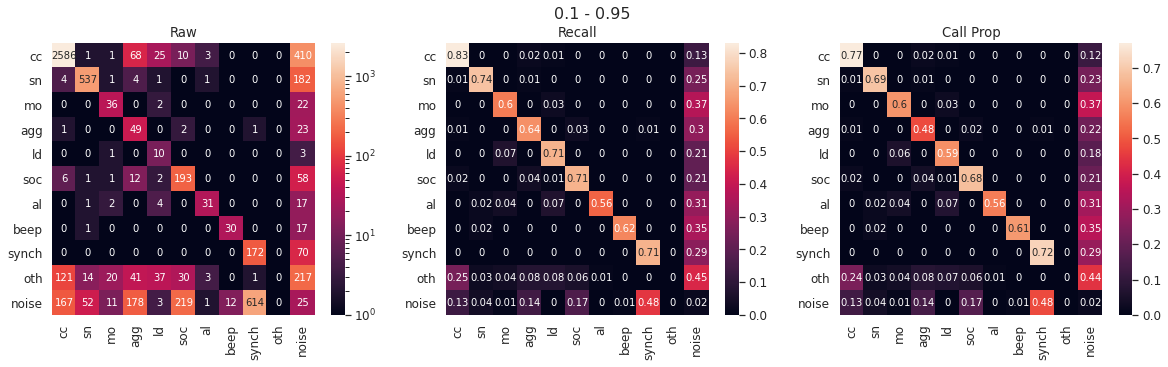

Epoch 1/200
39/39 [==============================] - 64s 2s/step - loss: 1.6781 - output_calltype_loss: 1.6670 - output_callpresence_loss: 0.2233 - output_calltype_categorical_accuracy: 0.6928 - output_callpresence_binary_accuracy: 0.6865 - val_loss: 1.5093 - val_output_calltype_loss: 1.4978 - val_output_callpresence_loss: 0.2302 - val_output_calltype_categorical_accuracy: 0.7127 - val_output_callpresence_binary_accuracy: 0.7259
Epoch 2/200
39/39 [==============================] - 57s 1s/step - loss: 1.2206 - output_calltype_loss: 1.2101 - output_callpresence_loss: 0.2091 - output_calltype_categorical_accuracy: 0.7206 - output_callpresence_binary_accuracy: 0.7195 - val_loss: 1.1395 - val_output_calltype_loss: 1.1299 - val_output_callpresence_loss: 0.1927 - val_output_calltype_categorical_accuracy: 0.7198 - val_output_callpresence_binary_accuracy: 0.7340
Epoch 3/200
39/39 [==============================] - 57s 1s/step - loss: 1.1845 - output_calltype_loss: 1.1744 - output_callpresence_l

Layer bidirectional_7 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_8:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).
Layer bidirectional_8 was passed non-serializable keyword arguments: {'mask': <tf.Tensor 'input_8:0' shape=(?, 201) dtype=float32>}. They will not be included in the serialized model (and thus will be missing at deserialization time).


/media/kiran/D0-P1/animal_data/meerkat/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_HM2017/trained_model/NoiseAugmented_0.3_0.8_NotWeighted_MaskedOther_Forked_trained_with_HM2017_2021-12-21_21:47:53.844906
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 201, 30, 1)   0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 201, 30, 128) 1280        input_7[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 201, 6, 128)  0           conv2d_10[0][0]                  
_______________________________________________________________________________


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


*****************************************************************
Low Threshold: 0.1
High Threshold: 0.5
Detecting calls in probability streams:  0 / 7199
Detecting calls in probability streams:  1000 / 7199
Detecting calls in probability streams:  2000 / 7199
Detecting calls in probability streams:  3000 / 7199
Detecting calls in probability streams:  4000 / 7199
Detecting calls in probability streams:  5000 / 7199
Detecting calls in probability streams:  6000 / 7199
Detecting calls in probability streams:  7000 / 7199
*****************************************************************
Low Threshold: 0.1
High Threshold: 0.6
Detecting calls in probability streams:  0 / 7199
Detecting calls in probability streams:  1000 / 7199
Detecting calls in probability streams:  2000 / 7199
Detecting calls in probability streams:  3000 / 7199
Detecting calls in probability streams:  4000 / 7199
Detecting calls in probability streams:  5000 / 7199
Detecting calls in probability streams:  6000 / 7199
D

<Figure size 432x288 with 0 Axes>

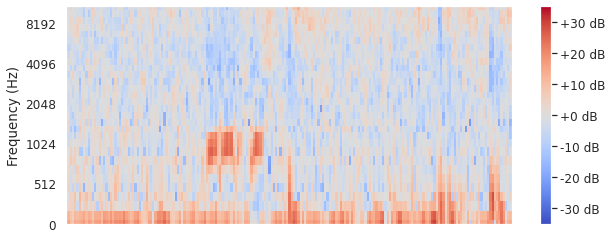

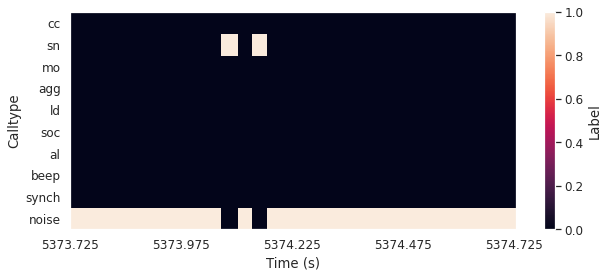

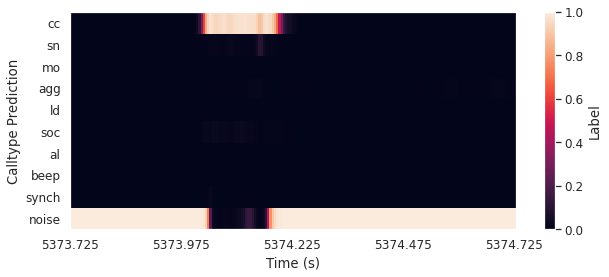

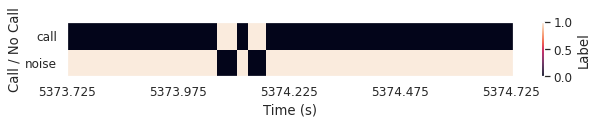

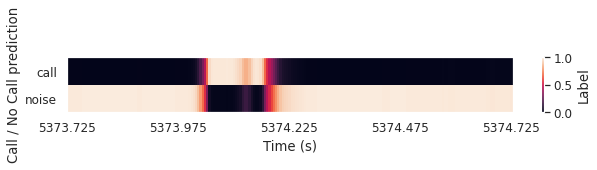

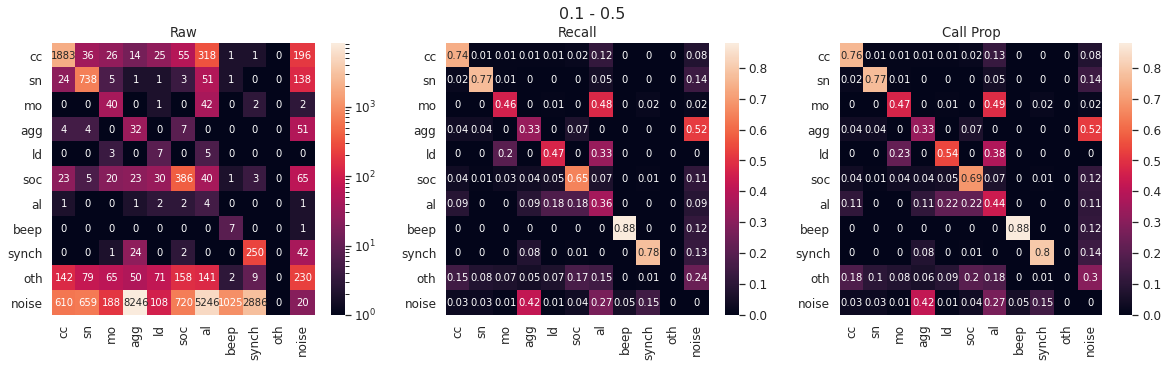

<Figure size 432x288 with 0 Axes>

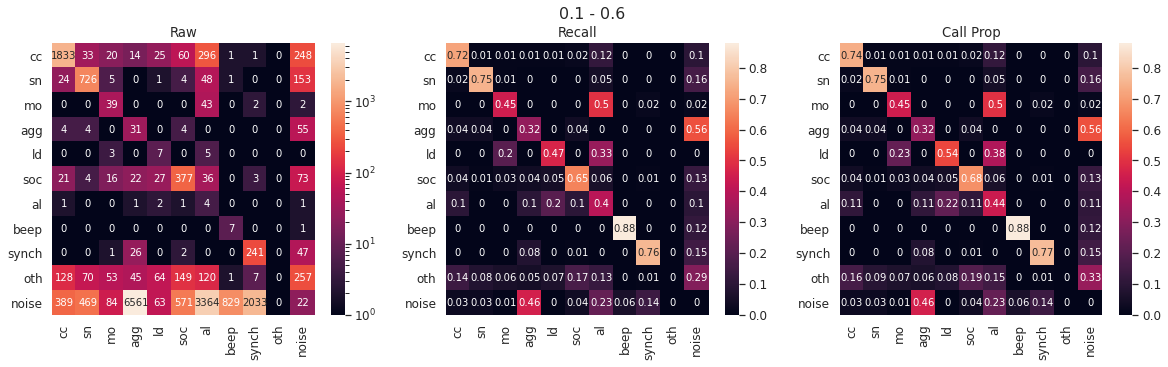

<Figure size 432x288 with 0 Axes>

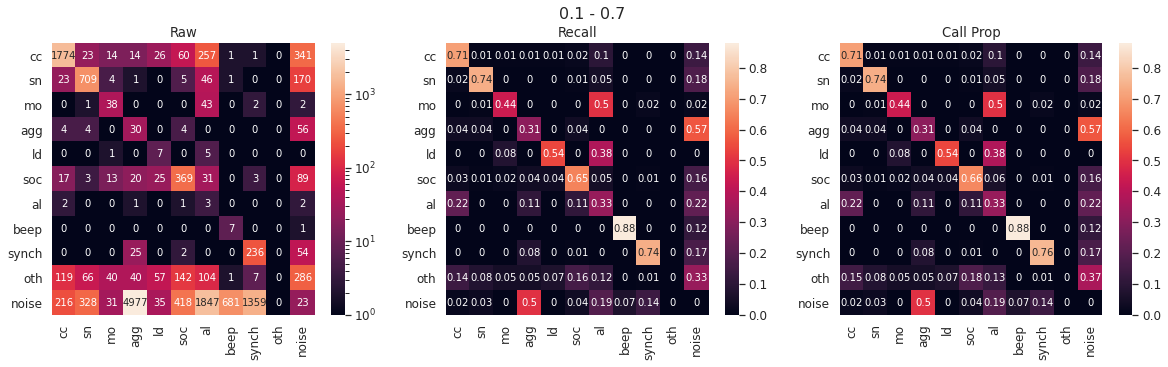

<Figure size 432x288 with 0 Axes>

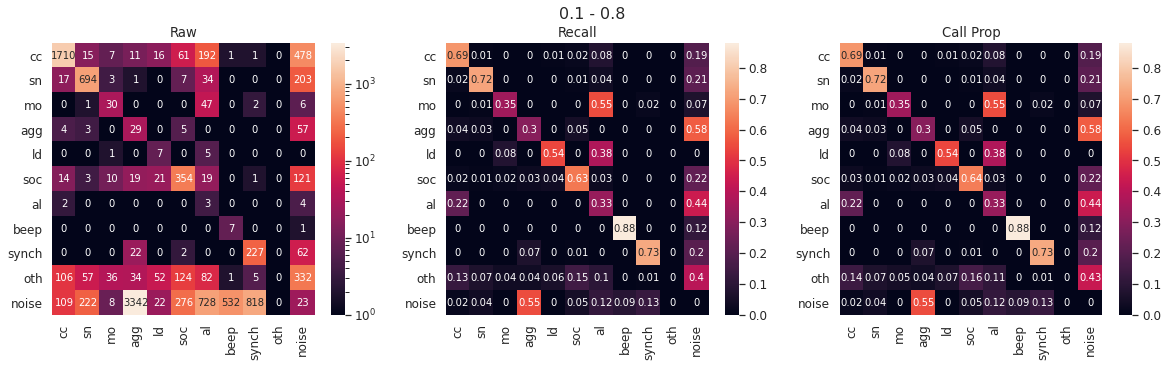

<Figure size 432x288 with 0 Axes>

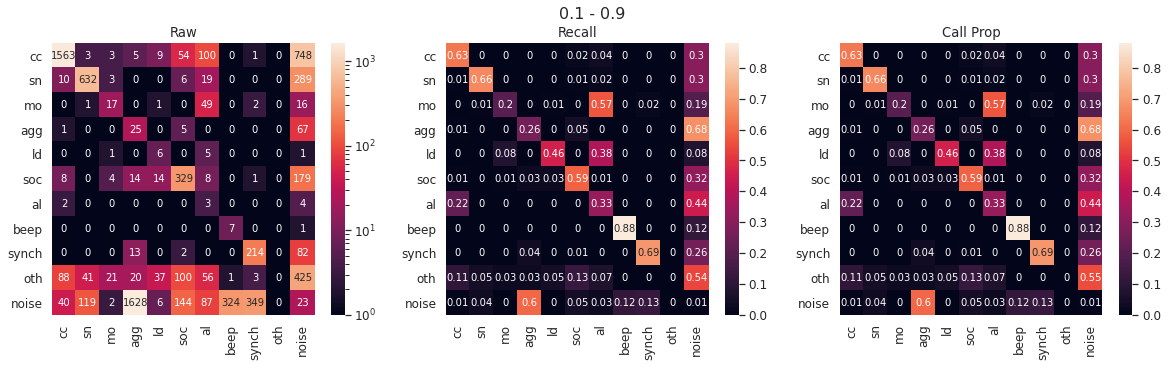

<Figure size 432x288 with 0 Axes>

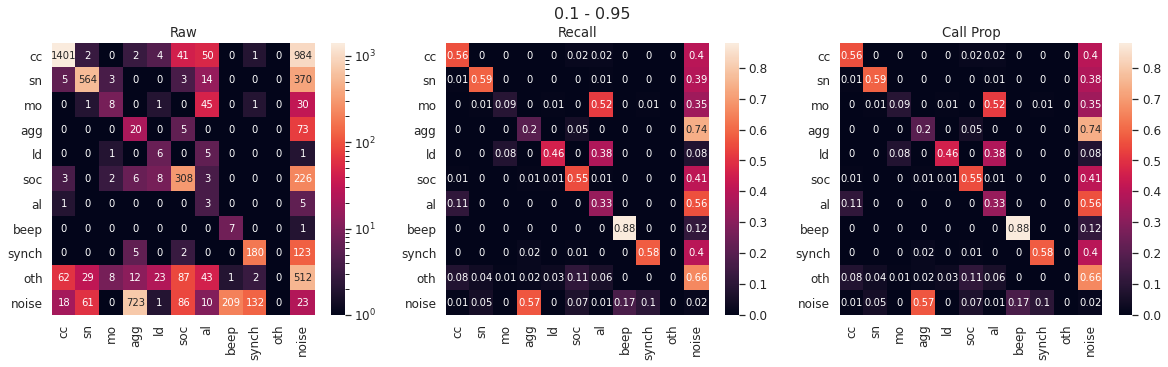

<Figure size 432x288 with 0 Axes>

In [9]:
train_pattern = [["L2019","HM2019"],["HM2017","HM2019"], ["L2019"], ["HM2017"]]

for sensitivity_i in train_pattern:  
    
    
    ### SETUP file structure for sensitivity runs
    #------------------------------------------------------------
    run_name = "NoiseAugmented_"+ str(min_scaling_factor)+"_" +str(max_scaling_factor)+"_NotWeighted_MaskedOther_Forked_trained_with_" + '_'.join(sensitivity_i)

    # basically the root directory for train, test and model
    save_data_path = os.path.join(results_dir, run_name)
    if not os.path.isdir(save_data_path):
        os.makedirs(save_data_path)

    # Test folders
    test_path = os.path.join(save_data_path, 'test_data')
    if not os.path.isdir(test_path):
        os.makedirs(test_path)


    save_pred_test_path = os.path.join(test_path , "predictions")
    if not os.path.isdir(save_pred_test_path):
        os.makedirs(save_pred_test_path)

    save_pred_stack_test_path = os.path.join(save_pred_test_path,"stacks")
    if not os.path.isdir(save_pred_stack_test_path):
        os.makedirs(save_pred_stack_test_path)        

    save_pred_table_test_path = os.path.join(save_pred_test_path,"pred_table")
    if not os.path.isdir(save_pred_table_test_path):
        os.makedirs(save_pred_table_test_path)

    save_label_table_test_path = os.path.join(test_path, 'label_table')
    if not os.path.isdir(save_label_table_test_path):
        os.makedirs(save_label_table_test_path)

    save_metrics_path = os.path.join(test_path , "metrics")
    if not os.path.isdir(save_metrics_path):
        os.makedirs(save_metrics_path)

    save_metrics_path_eval = os.path.join(save_metrics_path, eval_analysis)
    if not os.path.isdir(save_metrics_path_eval):
        os.makedirs(save_metrics_path_eval)


    # Model folder
    save_model_path = os.path.join(save_data_path, 'trained_model')
    if not os.path.isdir(save_model_path):
        os.makedirs(save_model_path)
       

    training_files = label_table['wavFileName'][label_table['group'].isin(sensitivity_i)].unique()
    testing_filenames = label_table['wavFileName'][label_table['group'].isin(sensitivity_i) == False].unique()
    
    if len(training_files) > 100:
        shuffle(training_files)
        training_files = training_files[0:100]
    
    if len(testing_filenames) > 11:
        shuffle(testing_filenames)
        testing_filenames = testing_filenames[0:11]
        
    
    # Split the training and test set based on the separation
    split_index = floor(len(training_files) * train_val_split )
    shuffle(training_files)
    training_filenames = training_files[:split_index]
    validation_filenames = training_files[split_index:]


    # save a copy of the training and testing diles
    with open(os.path.join(save_model_path, "training_files_used.txt"), "w") as f:
        for s in training_filenames:
            f.write(str(s) +"\n")
    with open(os.path.join(save_model_path, "testing_files_used.txt"), "w") as f:
        for s in testing_filenames:
            f.write(str(s) +"\n")
    with open(os.path.join(save_model_path, "validation_files_used.txt"), "w") as f:
        for s in validation_filenames:
            f.write(str(s) +"\n")


    '''Then we create a dictionary that will be used in the datagenerator. 
    Each key is a calltype and contains the start/stop/duration/filename where that call occurs. 
    This allows the data generator to shuffle them during the training.
    '''

    # separate out the training and test sets for analysis
    training_label_table = label_table[label_table['wavFileName'].isin(training_filenames)]
    testing_label_table = label_table[label_table['wavFileName'].isin(testing_filenames)]
    validation_label_table = label_table[label_table['wavFileName'].isin(validation_filenames)]

    # do the same for the noise
    training_noise_table = noise_table[noise_table['wavFileName'].isin(training_filenames)]
    testing_noise_table = noise_table[noise_table['wavFileName'].isin(testing_filenames)]
    validation_noise_table = noise_table[noise_table['wavFileName'].isin(validation_filenames)]

    # Compile training data into a format that the data generator can use
    training_label_dict = dict()
    for label in call_types: 
        training_label_dict[label] = training_label_table.loc[training_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
    training_label_dict[label_for_noise] = training_noise_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

    # Compile test data into a format that the data generator can use
    testing_label_dict = dict()
    for label in call_types: 
        testing_label_dict[label] = testing_label_table.loc[testing_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
    testing_label_dict[label_for_noise] = testing_noise_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

    # Compile validation data into a format that the data generator can use
    validation_label_dict = dict()
    for label in call_types: 
        validation_label_dict[label] = validation_label_table.loc[validation_label_table[label] == True, ["Label", "Start", "Duration","End","wav_path","label_path"]]
    validation_label_dict[label_for_noise] = validation_label_table[["Label", "Start", "Duration","End","wav_path","label_path"]]

    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------
    # TRAINING
    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------
    

    ## Build the training and validation data generators (for real this time)
    #---------------------------------------------------------------------------------------------
    


    if is_forked == True:
        # initiate the data generator
        train_generator = bg.ForkedDataGenerator(training_label_dict,
                                                 training_label_table, 
                                                 spec_window_size,
                                                 n_mels, 
                                                 window, 
                                                 fft_win , 
                                                 fft_hop , 
                                                 normalise,
                                                 label_for_noise,
                                                 label_for_other,
                                                 min_scaling_factor,
                                                 max_scaling_factor,
                                                 n_per_call,
                                                 other_ignored_in_training,
                                                 mask_value,
                                                 mask_vector)
        
        # get a batch to estimate rnn parameters
        x_train, y_train = train_generator.__next__()#__getitem__(0)

        # initial parameters
        num_calltypes = y_train[0].shape[2]
        gru_units = y_train[0].shape[1] 


        # initialise the training data generator and validation data generator
        train_generator = bg.ForkedDataGenerator(training_label_dict,
                                                 training_label_table, 
                                                 spec_window_size,
                                                 n_mels, 
                                                 window, 
                                                 fft_win , 
                                                 fft_hop , 
                                                 normalise,
                                                 label_for_noise,
                                                 label_for_other,
                                                 min_scaling_factor,
                                                 max_scaling_factor,
                                                 n_per_call,
                                                 other_ignored_in_training,
                                                 mask_value,
                                                 mask_vector)

        val_generator = bg.ForkedDataGenerator(validation_label_dict,
                                               validation_label_table, 
                                               spec_window_size,
                                               n_mels, 
                                               window, 
                                               fft_win , 
                                               fft_hop , 
                                               normalise,
                                               label_for_noise,
                                               label_for_other,
                                               min_scaling_factor,
                                               max_scaling_factor,
                                               n_per_call,
                                               other_ignored_in_training,
                                               mask_value,
                                               mask_vector)

    else:
        train_generator = bg.DataGenerator(training_label_dict,
                                                 training_label_table, 
                                                 spec_window_size,
                                                 n_mels, 
                                                 window, 
                                                 fft_win , 
                                                 fft_hop , 
                                                 normalise,
                                                 label_for_noise,
                                                 label_for_other,
                                                 min_scaling_factor,
                                                 max_scaling_factor,
                                                 n_per_call,
                                                 other_ignored_in_training,
                                                 mask_value,
                                                 mask_vector)
        x_train, y_train = train_generator.__next__()#__getitem__(0)

        # initial parameters
        num_calltypes = y_train[0].shape[2]
        gru_units = y_train[0].shape[1] 

        train_generator = bg.DataGenerator(training_label_dict,
                                                 training_label_table, 
                                                 spec_window_size,
                                                 n_mels, 
                                                 window, 
                                                 fft_win , 
                                                 fft_hop , 
                                                 normalise,
                                                 label_for_noise,
                                                 label_for_other,
                                                 min_scaling_factor,
                                                 max_scaling_factor,
                                                 n_per_call,
                                                 other_ignored_in_training,
                                                 mask_value,
                                                 mask_vector)

        val_generator = bg.DataGenerator(validation_label_dict,
                                               validation_label_table, 
                                               spec_window_size,
                                               n_mels, 
                                               window, 
                                               fft_win , 
                                               fft_hop , 
                                               normalise,
                                               label_for_noise,
                                               label_for_other,
                                               min_scaling_factor,
                                               max_scaling_factor,
                                               n_per_call,
                                               other_ignored_in_training,
                                               mask_value,
                                               mask_vector)    



    #---------------------------------------------------------------------------------------------
    ## CONSTRUCT THE RNN
    #---------------------------------------------------------------------------------------------

    # initialise the model class
    model = rnn.BuildNetwork(x_train, num_calltypes, filters, gru_units, dense_neurons, dropout, mask_value)

    # build the model
    if is_forked == True:
        RNN_model = model.build_forked_masked_rnn()

        # Multiple target losses
        losses = {
            'output_calltype' : 'categorical_crossentropy',  # classification
            'output_callpresence' : 'mse'  # regression 0-1
        }

        loss_weights = {
            'output_calltype' : 1.0,
            'output_callpresence' : 0.05  # Making this too large is not a good idea as we really want the network paying attention to class
        }
        accuracy_metrics = {
            'output_calltype' : 'categorical_accuracy',
            'output_callpresence' : 'binary_accuracy'
            
        }

    else:
        RNN_model = model.build_masked_rnn()
        # only one target loss
        losses = 'categorical_crossentropy'
        loss_weights = None
        accuracy_metrics = 'categorical_accuracy'

    # Adam optimiser
    adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

    # Compile the model
    #RNN_model.compile(optimizer=adam, loss=losses, loss_weights=loss_weights, metrics=['binary_accuracy'])
    RNN_model.compile(optimizer=adam, loss=losses, loss_weights=loss_weights, metrics = accuracy_metrics)

    # Setup callbycks: learning rate / loss /tensorboard
    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, verbose=1)
    reduce_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=25, verbose=1,
                                       mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.000001)
    loss = LossHistory()

    # setup a path with a timestamp
    date_time = datetime.datetime.now()
    date_now = str(date_time.date())
    time_now = str(date_time.time())
    save_tensorboard_path = os.path.join(save_model_path, "tensorboard_logs_" + date_now + "_" + time_now)
    if not os.path.isdir(save_tensorboard_path):
        os.makedirs(save_tensorboard_path)   

    # tensorboard
    tensorboard = TensorBoard(log_dir = save_tensorboard_path,
                              histogram_freq=0,
                              write_graph=True,  # Show the network
                              write_grads=True   # Show gradients
                              )  
    # fit model
    RNN_model.fit_generator(train_generator, 
                            steps_per_epoch = train_generator.__len__(),
                            epochs = epochs,
                            callbacks = [early_stopping, reduce_lr_plat, loss, tensorboard],
                            validation_data = val_generator,
                            validation_steps = val_generator.__len__())


    # Look at the model
    # plot_model(RNN_model, run_name + ".png", show_shapes=True)


    #---------------------------------------------------------------------------------------------
    ## SAVE THE MODEL
    #---------------------------------------------------------------------------------------------

    # save the model
    date_time = datetime.datetime.now()
    date_now = str(date_time.date())
    time_now = str(date_time.time())
    sf = os.path.join(save_model_path, run_name+ "_" + date_now + "_" + time_now)
    if not os.path.isdir(sf):
        os.makedirs(sf)

    RNN_model.save(sf + '/savedmodel' + '.h5')

    print(sf)

    test = load_model(sf + '/savedmodel' + '.h5')
    test.summary()
    #test.predict([spec])




    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------
    ## TESTING
    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------

    ## Predict over the test files
    #---------------------------------------------------------------------------------------------
    skipped_files = []

    # we only do one file in this example to avoid it running too long
    for file_ID in testing_filenames:
        # file_ID = testing_filenames[0] # for testing purposes only

        # subset the label table to only use that one file
        file_label_table = testing_label_table[testing_label_table['wavFileName'].isin([file_ID])]
        
        #sometimes the labels are missing and categorise those as "oth"
        file_label_table['Label'] = file_label_table['Label'].replace(np.nan, "oth")
        
        file_label_table = file_label_table.sort_values(by=['Start']).reset_index()
        # Find the file ID name i.e. remove the extention
        file_ID = file_ID.split(".")[0] 
        # find the matching audio for the label data
        audio_path = file_label_table["wav_path"][0]   

        print("*****************************************************************")   
        print("*****************************************************************") 
        print ("File being processed : " + audio_path)    

        # find the start and stop  of the labelling periods (also using skipon/skipoff)
        loop_table = file_label_table.loc[file_label_table["Label"].str.contains('|'.join(label_for_startstop), regex=True, case = False), ["Label","Start"]]
        loop_times = list(loop_table["Start"])

        # Make sure that the file contains the right number of start and stops, otherwise go to the next file
        if len(loop_times)%2 != 0:
            print("!!!!!!!!!!!!!!!!")
            warnings.warn("There is a missing start or stop in this file and it has been skipped: " + audio_path)
            skipped_files.append(file_ID)
            continue 

        if len(loop_times) == 0:
            print("!!!!!!!!!!!!!!!!")
            warnings.warn("There is a missing start or stop in this file and it has been skipped: " + audio_path)
            skipped_files.append(file_ID)
            continue 

        # save the label_table
        save_label_table_filename = file_ID + "_LABEL_TABLE.txt"
        file_label_table.to_csv(os.path.join(save_label_table_test_path, save_label_table_filename), 
                            header=True, index=None, sep=';')

        # load the audio data
        y, sr = librosa.load(audio_path, sr=None, mono=False)

        # # Reshaping the Audio file (mono) to deal with all wav files similarly
        # if y.ndim == 1:
        #     y = y.reshape(1, -1)

        # # Implement this for acc data
        # for ch in range(y.shape[0]):
        # ch=0
        # y_sub = y[:,ch]
        y_sub = y

        # loop through every labelling start based on skipon/off within this loop_table
        for loopi in range(0, int(len(loop_times)), 2):
            # loopi = 0
            fromi =  loop_times[loopi]
            #toi = fromi + 5
            toi = loop_times[int(loopi + 1)] # define the end of the labelling periods

            calltype_pred_list = []
            callpresence_pred_list = []
            # if the file exists, load it
            if os.path.exists(os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy')): 
                calltype_pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy')) 
                callpresence_pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'))


            # if the file is incomplete or non existant redo it
            if (len(np.arange(fromi, toi, slide)) - sum(np.arange(fromi, toi, slide)+spec_window_size > toi)) != (len(calltype_pred_list)):

                for spectro_slide in np.arange(fromi, toi, slide):                
                    # spectro_slide = fromi
                    start = round(spectro_slide,3)
                    stop = round(spectro_slide + spec_window_size, 3)

                    # ignore cases where the window is larger than what is labelled (e.g. at the end)
                    if stop <= toi:

                        #generate the spectrogram
                        spectro = pre.generate_mel_spectrogram(y=y_sub, sr=sr, start=start, stop=stop, 
                                                                n_mels = n_mels, window='hann', 
                                                                fft_win= fft_win, fft_hop = fft_hop, 
                                                                normalise = True)

                        # transpose it and put it in a format that works with the NN
                        spec = spectro.T
                        spec = spec[np.newaxis, ..., np.newaxis]  

                        # generate a mask (as a placeholder) but don't mask anything as we are predicting and want to include other
                        mask = np.asarray([True for i in range(spectro.shape[1])])
                        mask = mask[np.newaxis,...]

                        # generate the prediction
                        pred = RNN_model.predict([spec,mask])

                        # add this prediction to the stack that will be used to generate the predictions table
                        if is_forked:
                            calltype_pred_list.append(np.squeeze(pred[0]))
                            callpresence_pred_list.append(np.squeeze(pred[1]))
                        else:
                            calltype_pred_list.append(np.squeeze(pred))

                # save the prediction stacks
                np.save( os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'), calltype_pred_list)
                with open(os.path.join(save_pred_stack_test_path, file_ID + '_CALLTYPE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.txt'), "w") as f:
                    for row in calltype_pred_list:
                        f.write(str(row) +"\n")
                if is_forked:      
                    np.save( os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.npy'), callpresence_pred_list)
                    with open(os.path.join(save_pred_stack_test_path, file_ID + '_CALLPRESENCE_PRED_STACK_' + str(fromi) + '-' + str(toi) + '.txt'), "w") as f:
                        for row in callpresence_pred_list:
                            f.write(str(row) +"\n")

            # Loop through different sets of thresholds
            for low_thr in [0.1]:
                for high_thr in [0.5,0.6,0.7,0.8,0.9,0.95]: 

                    # make sure it doesnt generate a 0.00098982374957839486 type number
                    low_thr = round(low_thr,2)                               
                    high_thr = round(high_thr,2)

                    # stop the loop if the low threshold is bigger than the high threshold
                    if low_thr >= high_thr:
                        continue

                    save_pred_table_filename = file_ID + "_CALLTYPE_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + ".txt"

                    # if the file exists, pass to the next iteration of the loop
                    #if os.path.exists(os.path.join(save_pred_table_test_path, save_pred_table_filename)):
                    #    continue

                    print("*****************************************************************") 
                    print ("Low Threshold: " + str(low_thr))    
                    print ("High Threshold: " + str(high_thr))  

                    #----------------------------------------------------------------------------
                    # Compile the predictions for each on/off labelling chunk
                    detections = ppm.merge_p(probabilities = calltype_pred_list, 
                                              labels=list(call_types.keys()),
                                              starttime = 0, 
                                              frameadv_s = fft_hop, 
                                              specadv_s = slide,
                                              low_thr=low_thr, 
                                              high_thr=high_thr, 
                                              debug=1)

                    #in case the dataset was just noise, still create an empty placeholder to merge
                    if len(detections) == 0:  
                        detections = pd.DataFrame(columns = ['category', 'start', 'end', 'scores'])

                    # create an empty dataset
                    pred_table = pd.DataFrame() 

                    #convert these detections to a predictions table                
                    table = pd.DataFrame(detections)
                    table["Label"] = table["category"]
                    table["Start"] = round(table["start"]*fft_hop + fromi, 3) #table["start"].apply(Decimal)*Decimal(fft_hop) + Decimal(fromi)
                    table["Duration"] = round( (table["end"]-table["start"])*fft_hop, 3) #(table["end"].apply(Decimal)-table["start"].apply(Decimal))*Decimal(fft_hop)
                    table["End"] = round(table["end"]*fft_hop + fromi, 3) #table["Start"].apply(Decimal) + table["Duration"].apply(Decimal)

                    # keep only the useful columns    
                    table = table[["Label","Start","Duration", "End", "scores"]]  

                    # Add a row which stores the start of the labelling period
                    row_start = pd.DataFrame()
                    row_start.loc[0,'Label'] = list(loop_table["Label"])[loopi]
                    row_start.loc[0,'Start'] = fromi
                    row_start.loc[0,'Duration'] = 0
                    row_start.loc[0,'End'] = fromi 
                    row_start.loc[0,'scores'] = [0] 

                    # Add a row which stores the end of the labelling period
                    row_stop = pd.DataFrame()
                    row_stop.loc[0,'Label'] = list(loop_table["Label"])[int(loopi + 1)]
                    row_stop.loc[0,'Start'] = toi
                    row_stop.loc[0,'Duration'] = 0
                    row_stop.loc[0,'End'] = toi 
                    row_stop.loc[0,'scores'] = [0]       

                    # add the true false columns based on the call types dictionary
                    for true_label in call_types:
                        table[true_label] = False
                        row_start[true_label] = False
                        row_stop[true_label] = False
                        for old_label in call_types[true_label]:
                            table.loc[table["Label"].str.contains(old_label, regex=True, case = False), true_label] = True

                    # make sure start and stop are not classified as calls
                    row_start[label_for_noise] = True
                    row_stop[label_for_noise] = True

                    # put these rows to the label table
                    table = pd.concat([row_start, table, row_stop]) 

                    # add this table to the overall predictions table for that collar
                    pred_table = pd.concat([pred_table, table ])

                    # for each on/off labelling chunk, we can save the prediction and append it to the previous chunk
                    if loopi == 0:                    
                        # for the first chunck keep the header, but not when appending later. Also, overwrite old runs
                        pred_table.to_csv(os.path.join(save_pred_table_test_path, save_pred_table_filename), 
                                          header=True, index=None, sep=';', mode = 'w')
                    else:
                        pred_table.to_csv(os.path.join(save_pred_table_test_path, save_pred_table_filename), 
                                          header=None, index=None, sep=';', mode = 'a')

    '''
    # # load the saved file
    # with open(os.path.join(save_pred_stack_test_path, file_ID + '_PRED_STACK.txt')) as f:
    #     content = f.readlines()
    # # remove whitespace characters like `\n` at the end of each line
    # pred_list = [x.strip() for x in content] 


    # #or
    # pred_list = np.load( os.path.join(save_pred_stack_test_path, file_ID + '_PRED_STACK.npy'))
    # '''

    # save the files that were skipped
    print(skipped_files)

    # save a copy of the training and testing diles
    with open(os.path.join(save_model_path, "skipped_testing_files.txt"), "w") as f:
        for s in skipped_files:
            f.write(str(s) +"\n")


    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------
    ## TESTING
    #---------------------------------------------------------------------------------------------
    #---------------------------------------------------------------------------------------------

    # because of new file format, need to only keep certain columns so that the evaluation metrics work with the label tables
    column_names = ["Label","Start","Duration","End"]
    column_names.extend(list(testing_label_dict.keys()))  

    file_ID_list = [file_ID.split(".")[0] for file_ID in testing_filenames if file_ID.split(".")[0] not in skipped_files]
    labels_list =  [os.path.join(save_label_table_test_path,file_ID.split(".")[0]  + "_LABEL_TABLE.txt" ) for file_ID in file_ID_list]
    
    # get rid of duplicates
    for file in labels_list :
        df = pd.read_csv(file, delimiter=';') 
        # df = df.drop_duplicates(keep=False)
        df = df[column_names]
        df.to_csv(file, header=True, index=None, sep=';', mode = 'w')

    for low_thr in [0.1]:
        for high_thr in [0.5,0.6,0.7,0.8,0.9,0.95]: 

            low_thr = round(low_thr,2)                               
            high_thr = round(high_thr,2) 
            print("**********************************************************")
            print("Evaluating thresholds: " + str(low_thr) + "-" + str(high_thr))
            print("**********************************************************")

            if low_thr >= high_thr:
                continue

            pred_list = [os.path.join(save_pred_table_test_path,file_ID.split(".")[0]  + "_CALLTYPE_PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + ".txt" ) for file_ID in file_ID_list ]
            evaluation = metrics.Evaluate(label_list = labels_list, 
                                          prediction_list = pred_list, 
                                          noise_label = "noise", 
                                          IoU_threshold = 0.2, 
                                          call_analysis = eval_analysis, 
                                          GT_proportion_cut = 0.01, 
                                          no_call = no_call,
                                          headers = set(['Label', 'Duration', 'Start', 'End']),
                                          nonfoc_tags =["NONFOC", "nf", "*"]
                                         ) # 0.99 is 0.5
            output, skipped_calls = evaluation.main()        
            print(str(skipped_calls) + " calls were skipped in total")

            to_pickle = ["Time_Difference", "Matching_Table", "Prediction_Indices", "Label_Indices" , "_Match"]
            for metric in output.keys():
                if any(ext in metric for ext in to_pickle):
                    filename = "PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_" +str(metric) +".p"
                    with open(os.path.join(save_metrics_path_eval, filename), 'wb') as fp:
                        pickle.dump(output[metric], fp) 
                else:
                    filename = "PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + "_" +str(metric) +".csv"
                    output[metric].to_csv(os.path.join(save_metrics_path_eval, filename))    


    #--------------------------------------------------------------------------------------------
    # PLOT A PREDICTION
    #--------------------------------------------------------------------------------------------


    pool = audiopool.AudioPool() 

    # Find a call
    call = testing_label_dict["sn"].iloc[15]
    label_subset = testing_label_table[testing_label_table['wav_path'].isin([call["wav_path"]])]

    # set the labels
    label_list = list(call_types.keys())
    if other_ignored_in_training:
        label_list.remove(label_for_other)


    # randomise the start a little so the new spectrogram will be a little different from the old
    # if the call is very long have a large range to draw the window
    if call["Duration"]>= spec_window_size:
        call_start = round(float(np.random.uniform(call["Start"]-spec_window_size/2, 
                                                   call["End"]-spec_window_size/2, 1)), 3)
    # if the call is short call, draw it from somewhere
    else:
        call_start = round(float(np.random.uniform((call["Start"]+call["End"])/2-spec_window_size, 
                                                   (call["Start"]+call["End"])/2)), 3)

    # load in a subsection of the spectrogram
    # y, sr = librosa.load(call["wav_path"], sr=None, mono=False,
    #                      offset = call_start, duration =self.spec_window_size)
    y = pool.get_seconds(call["wav_path"], call_start, spec_window_size)
    sr = pool.get_Fs(call["wav_path"])

    call_stop = round(call_start + spec_window_size,3 )

    # have it as an array
    data_subset = np.asfortranarray(y)

    #get the spectrogram
    spectrogram = pre.generate_mel_spectrogram(data_subset, sr, 0, spec_window_size, 
                                               n_mels, window, fft_win , fft_hop , normalise)

    # generate label
    label = pre.create_label_matrix(label_subset, 
                                    spectrogram, 
                                    testing_label_dict, 
                                    call_start, 
                                    call_stop, 
                                    label_for_noise, 
                                    label_for_other, 
                                    other_ignored_in_training)
    # plot spectrogram
    plt.figure(figsize=(10,4))
    #plt.subplot(411)
    yaxis = range(0, np.flipud(spectrogram).shape[0]+1)
    xaxis = range(0, np.flipud(spectrogram).shape[1]+1)
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    librosa.display.specshow(spectrogram,  y_axis='mel', x_coords = label.columns)#, x_axis= "time",sr=sr, x_coords = label.columns)
    plt.ylabel('Frequency (Hz)')
    plt.clim(-35, 35)
    plt.colorbar(format='%+2.0f dB')
    plt.show()

    # plot LABEL
    #plt.subplot(412)
    #print(label.shape)
    plt.figure(figsize=(10, 4))
    xaxis = range(0, np.flipud(label).shape[1]+1)
    yaxis = range(0, np.flipud(label).shape[0]+1)
    plt.yticks(np.arange(0.5, len(label_list)+0.5 ,1 ),reversed(label_list))
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    plt.pcolormesh(xaxis, yaxis, np.flipud(label))
    plt.clim(0, 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Calltype')
    plt.colorbar(label="Label")
    plt.show()

    if is_forked:
        # generate matrix of call/not call
        callmat = pre.create_call_matrix(label_subset, spectrogram, call_start, call_stop, 
                                          label_for_noise, label_for_other, other_ignored_in_training)

    # prediction
    # transpose it and put it in a format that works with the NN
    spec = spectrogram.T
    spec = spec[np.newaxis, ..., np.newaxis]  

    # generate a mask (as a placeholder) but don't mask anything as we are predicting and want to include other
    mask = np.asarray([True for i in range(spectrogram.shape[1])])
    mask = mask[np.newaxis,...]

    # generate the prediction
    pred = RNN_model.predict([spec,mask])

    # add this prediction to the stack that will be used to generate the predictions table
    if is_forked:
        calltype_pred= pred[0]
        callpresence_pred = pred[1]   
    else:
        calltype_pred = pred

    pred = calltype_pred[0].T

    #print(pred.shape)
    #plot calltype prediction
    plt.figure(figsize=(10, 4))
    xaxis = range(0, np.flipud(label).shape[1]+1)
    yaxis = range(0, np.flipud(label).shape[0]+1)
    plt.yticks(np.arange(0.5, len(label_list)+0.5 ,1 ),reversed(label_list))
    plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
               list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
    plt.pcolormesh(xaxis, yaxis, np.flipud(pred))
    plt.clim(0, 1)
    plt.xlabel('Time (s)')
    plt.ylabel('Calltype Prediction')
    plt.colorbar(label="Label")
    plt.show()


    if is_forked:  
        # plot call matrix
        #plt.subplot(413)
        plt.figure(figsize=(10, 1))
        xaxis = range(0, np.flipud(label).shape[1]+1)
        yaxis = range(0, np.flipud(callmat).shape[0]+1)
        plt.yticks(np.arange(0.5, callmat.shape[0]+0.5 ,1 ), reversed(callmat.index.values))
        plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(callmat))
        plt.clim(0, 1)
        plt.xlabel('Time (s)')
        plt.ylabel('Call / No Call')
        plt.colorbar(label="Label")
        plt.show()

        pred = callpresence_pred[0].T
        #plot prediction
        plt.figure(figsize=(10, 1))
        xaxis = range(0, np.flipud(label).shape[1]+1)
        yaxis = range(0, np.flipud(callmat).shape[0]+1)
        plt.yticks(np.arange(0.5, callmat.shape[0]+0.5 ,1 ), reversed(callmat.index.values))
        plt.xticks(np.arange(0, np.flipud(label).shape[1]+1,50),
                   list(label.columns[np.arange(0, np.flipud(label).shape[1]+1,50)]))
        plt.pcolormesh(xaxis, yaxis, np.flipud(pred))
        plt.clim(0, 1)
        plt.xlabel('Time (s)')
        plt.ylabel('Call / No Call prediction')
        plt.colorbar(label="Label")
        plt.show()

    #--------------------------------------------------------------------------------------------
    # CONFUSION MATRIX
    #--------------------------------------------------------------------------------------------

    # loop over the threaholdsf
    for low_thr in [0.1]:
        for high_thr in [0.5,0.6,0.7,0.8,0.9,0.95]:     
            #########################################
            # FORMAT 

            low_thr = round(low_thr,2)                               
            high_thr = round(high_thr,2) 

            if low_thr >= high_thr:
                continue
            if low_thr == 0.1 and high_thr == 0.2:
                continue

            if eval_analysis == "normal":
                confusion_filename = os.path.join(save_metrics_path_eval, "PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '_foc_Confusion_Matrix.csv')
            else:
                confusion_filename = os.path.join(save_metrics_path_eval, "PRED_TABLE_thr_" + str(low_thr) + "-" + str(high_thr) + '__Confusion_Matrix.csv')
            with open(confusion_filename, newline='') as csvfile:
                array = list(csv.reader(csvfile))

            df_cm = pd.DataFrame(array) #, range(6), range(6))    

            # get rid of the weird indentations and make rows and columns as names
            new_col = df_cm.iloc[0] # grab the first row for the header
            df_cm = df_cm[1:] # take the data less the header row
            df_cm.columns = new_col # set the header row as the df header    
            new_row = df_cm['']
            df_cm = df_cm.drop('', 1)
            df_cm.index = new_row
            df_cm.index.name= None
            df_cm.columns.name= None

            # # replace FP and FN with noise
            df_cm['noise'] = df_cm['FN'] 
            #df_cm.loc['noise']=df_cm.loc['FP']

            # remove FP and FN
            df_cm = df_cm.drop("FN", axis=1)
            #df_cm = df_cm.drop("FP", axis=0)

            df_cm = df_cm.apply(pd.to_numeric)

            # Raw confusion matrix
            df_cm = df_cm[list(testing_label_dict.keys())]
            df_cm = df_cm.reindex(list(testing_label_dict.keys()))       

            #########################################
            # CALCULATE

            # Recall confusion matrix
            df_recall = df_cm.div(df_cm.sum(axis=1), axis=0).round(2)#pd.DataFrame(df_cm.values / df_cm.sum(axis=1).values).round(2)

            # Proportion of calls for confusion matrix
            call_len = list()
            for i in testing_label_dict.keys():
                call_len.append(testing_label_dict[i].shape[0])
            # add noise at the end
            call_len[-1] = df_cm.sum(axis=1)[-1]

            #proportion of calls
            df_prop = df_cm.div(call_len, axis=0).round(2)#pd.DataFrame(df_cm.values / df_cm.sum(axis=1).values).round(2)

            #########################################
            # PLOT

            #multi figure parameters
            fig,((ax1,ax2,ax3)) = plt.subplots(1,3, figsize=(20,5))
            fig.suptitle(str(low_thr) + " - " + str(high_thr))

            # plot raw
            sn.set(font_scale=1.1) # for label size
            sn.heatmap((df_cm+1), annot=df_cm, fmt='g',norm = LogNorm(), annot_kws={"size": 10}, ax= ax1) # font size
            ax1.set_title("Raw")              

            # plot recall
            sn.set(font_scale=1.1) # for label size
            sn.heatmap((df_recall), annot=True, fmt='g', annot_kws={"size": 10}, ax= ax2) # font size
            ax2.set_title("Recall" )

            # plot proportion of calls
            sn.set(font_scale=1.1) # for label size
            sn.heatmap((df_prop), annot=True, fmt='g', annot_kws={"size": 10}, ax= ax3) # font size
            ax3.set_title("Call Prop")

            # Save 3 panels
            plt.savefig(os.path.join(save_metrics_path, eval_analysis, "Confusion_mat_thr_" + str(low_thr) + "-" + str(high_thr) + '.png'))
            plt.show()
            plt.clf()

In [13]:
testing_label_table.columns
file_label_table.columns

Index(['level_0', 'index', 'Label', 'Start', 'Duration', 'End', 'cc', 'sn',
       'mo', 'agg', 'ld', 'soc', 'al', 'beep', 'synch', 'oth', 'noise',
       'wavFileName', 'csvFileName', 'date', 'ind', 'group', 'callType',
       'isCall', 'focalType', 'hybrid', 'noisy', 'unsureType', 'wav_path',
       'label_path'],
      dtype='object')